In [176]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [594]:
def norm(data):
    return (data)/(max(data))

In [595]:
norm(appa1.CO)

72       0.363636
73       0.365751
74       0.365398
75       0.387949
76       0.372798
           ...   
17646    0.432699
17647    0.416138
17648    0.411910
17649    0.416490
17650    0.416490
Name: CO, Length: 17578, dtype: float64

In [139]:
appa1 = pd.read_csv("data/appa1_gt_clean.csv")
appa2 = pd.read_csv("data/appa2_gt_clean.csv")
appa1 = appa1[appa1["PM10"] != "n.d."]
appa2 = appa2[appa2["PM10"] != "n.d."]

In [140]:
appa1.columns = ['Time', 'PM10', 'NO2', 'SO2', 'O3']
appa2.columns = ['Time', 'PM10', 'CO', 'NO2']

In [141]:
appa1.PM10 = appa1.PM10.astype("float")

In [142]:
print(appa2.columns)
appa1.columns

Index(['Time', 'PM10', 'CO', 'NO2'], dtype='object')


Index(['Time', 'PM10', 'NO2', 'SO2', 'O3'], dtype='object')

### Graphs

**CO and NO2 during a week**

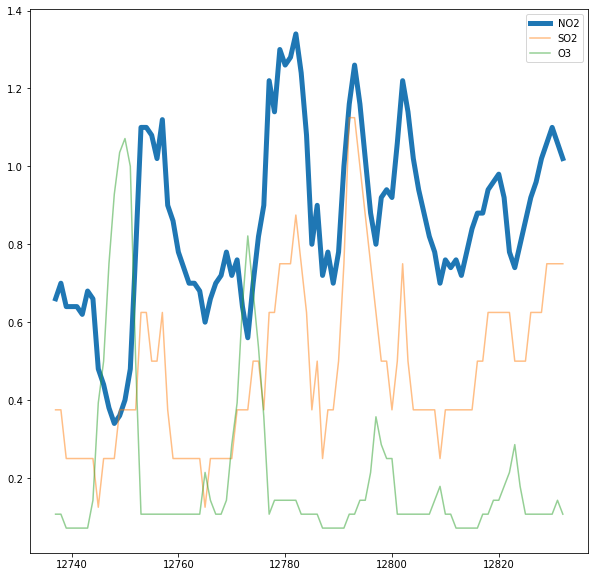

In [59]:
fig = plt.figure(figsize=(10,10))
plt.plot(norm(appa1[(appa1["Time"] > '2022-01-01') & (appa1["Time"] < '2022-01-05')].NO2), label="NO2", linewidth=5)
plt.plot(norm(appa1[(appa1["Time"] > '2022-01-01') & (appa1["Time"] < '2022-01-05')].SO2), label="SO2", alpha=0.5)
plt.plot(norm(appa1[(appa1["Time"] > '2022-01-01') & (appa1["Time"] < '2022-01-05')].O3), label="O3", alpha=0.5)
plt.legend()
plt.show()

**APPA 1**
Correlation Matrix

In [54]:
corr = appa1[(appa1["Time"] > '2022-01-01') & (appa1["Time"] < '2022-01-31')][["PM10", "NO2", "SO2", "O3"]].corr()
corr.style.background_gradient(cmap="coolwarm")

,PM10,NO2,SO2,O3
PM10,1.000000,0.540589,0.473543,-0.590956
NO2,0.540589,1.000000,0.756000,-0.731285
SO2,0.473543,0.756000,1.000000,-0.472522
O3,-0.590956,-0.731285,-0.472522,1.000000


**APPA 2**
Correlation Matrix

In [55]:
corr = appa2[(appa2["Time"] > '2022-01-01') & (appa2["Time"] < '2022-01-31')][["PM10", "CO", "NO2"]].corr()
corr.style.background_gradient(cmap="coolwarm")

,PM10,CO,NO2
PM10,1.000000,0.851578,0.638649
CO,0.851578,1.000000,0.816147
NO2,0.638649,0.816147,1.000000


### Modelling

In [384]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,median_absolute_error, mean_absolute_error

In [539]:
appa2.Time = pd.to_datetime(appa2.Time)

In [555]:
import math

dfx["time"] = dfx["Time"].dt.hour
dfx["month"] = dfx["Time"].dt.month


dfx["weekend"] = (
    dfx["Time"].dt.dayofweek >= 4
).astype("int")

dfx["sin_time"] = dfx["time"].apply(
    lambda x: math.sin(x) * 2 * (math.pi / 24)
)
dfx["cos_time"] = dfx["time"].apply(
    lambda x: math.cos(x) * 2 * (math.pi / 24)
)

dfx["sin_month"] = dfx["month"].apply(
    lambda x: math.sin(x) * 2 * (math.pi / 12)
)

dfx["cos_month"] = dfx["month"].apply(
    lambda x: math.cos(x) * 2 * (math.pi / 12)
)

In [144]:
appa2

,Time,PM10,CO,NO2
0,2020-07-31 01:00:00,16.0,0.6,8.0
1,2020-07-31 02:00:00,16.0,0.6,7.0
2,2020-07-31 03:00:00,16.0,0.6,8.0
3,2020-07-31 04:00:00,17.0,0.5,11.0
4,2020-07-31 05:00:00,18.0,0.6,15.0
...,...,...,...,...
17063,2022-07-25 20:00:00,31.0,0.8,13.0
17064,2022-07-25 21:00:00,30.0,0.8,12.0
17065,2022-07-25 22:00:00,22.0,0.8,6.0
17066,2022-07-25 23:00:00,30.0,0.8,10.0


In [565]:
[c for c in cols[:2]]

In [579]:
sliding = 96
cols = ["PM10", "NO2"]
start = len(cols)
for i in range(sliding):
	for x in range(start):
		cols.append(f"{cols[x]}_{i}")
cols.append("Time")
dfx = pd.DataFrame(columns=cols)
buff = [[r[c] for c in cols[:start]] for i,r in appa2.iloc[:sliding].iterrows()]
for i, row in tqdm(appa2.iloc[sliding:].iterrows(), total=len(appa2)):
	row_to_add = [row[c] for c in cols[:start]]
	for slid in range(sliding):
		row_to_add.extend(buff[slid][c] for c in range(len(cols[:start])))
	buff.insert(0,[row[c] for c in cols[:start]])
	buff.pop(-1)
	row_to_add.append(row["Time"])
	dfx.loc[i - sliding] = row_to_add

 99%|█████████▉| 16972/17068 [03:40<00:01, 77.01it/s]


In [535]:
dfx

,PM10,NO2,PM10_0,NO2_0,PM10_1,NO2_1,PM10_2,NO2_2,Time
0,17.0,11.0,16.0,8.0,16.0,7.0,16.0,8.0,2020-07-31 04:00:00
1,18.0,15.0,17.0,11.0,16.0,8.0,16.0,7.0,2020-07-31 05:00:00
2,19.0,31.0,18.0,15.0,17.0,11.0,16.0,8.0,2020-07-31 06:00:00
3,20.0,37.0,19.0,31.0,18.0,15.0,17.0,11.0,2020-07-31 07:00:00
4,20.0,30.0,20.0,37.0,19.0,31.0,18.0,15.0,2020-07-31 08:00:00
...,...,...,...,...,...,...,...,...,...
1764,9.0,67.0,5.0,46.0,5.0,44.0,5.0,58.0,2020-10-13 20:00:00
1765,15.0,57.0,9.0,67.0,5.0,46.0,5.0,44.0,2020-10-13 21:00:00
1766,18.0,50.0,15.0,57.0,9.0,67.0,5.0,46.0,2020-10-13 22:00:00
1767,11.0,27.0,18.0,50.0,15.0,57.0,9.0,67.0,2020-10-13 23:00:00


In [580]:
cols.remove("Time")
#cols.extend(['time', 'month', 'weekend', 'sin_time', 'cos_time', 'sin_month', 'cos_month'])

In [581]:
vsplit = round(len(appa2) * 0.3)

X_train = dfx.loc[vsplit:][cols]
X_test = dfx.loc[:vsplit][cols]

Y_train = appa2.loc[sliding + vsplit:][["CO"]]
Y_test = appa2.loc[sliding:vsplit+sliding][["CO"]]

In [451]:
X_train

,PM10,NO2,PM10_1,NO2_1,PM10_2,NO2_2,PM10_3,NO2_3,PM10_4,NO2_4,...,PM10_67,NO2_67,PM10_68,NO2_68,PM10_69,NO2_69,PM10_70,NO2_70,PM10_71,NO2_71
3414,23.0,23.0,24.0,23.0,29.0,25.0,26.0,26.0,27.0,28.0,...,32.0,52.0,28.0,50.0,28.0,35.0,29.0,37.0,32.0,40.0
3415,20.0,23.0,23.0,23.0,24.0,23.0,29.0,25.0,26.0,26.0,...,39.0,67.0,32.0,52.0,28.0,50.0,28.0,35.0,29.0,37.0
3416,17.0,24.0,20.0,23.0,23.0,23.0,24.0,23.0,29.0,25.0,...,40.0,67.0,39.0,67.0,32.0,52.0,28.0,50.0,28.0,35.0
3417,16.0,24.0,17.0,24.0,20.0,23.0,23.0,23.0,24.0,23.0,...,38.0,49.0,40.0,67.0,39.0,67.0,32.0,52.0,28.0,50.0
3418,16.0,22.0,16.0,24.0,17.0,24.0,20.0,23.0,23.0,23.0,...,35.0,51.0,38.0,49.0,40.0,67.0,39.0,67.0,32.0,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16991,31.0,13.0,28.0,16.0,26.0,18.0,24.0,20.0,22.0,13.0,...,38.0,22.0,37.0,27.0,35.0,41.0,32.0,39.0,29.0,28.0
16992,30.0,12.0,31.0,13.0,28.0,16.0,26.0,18.0,24.0,20.0,...,38.0,22.0,38.0,22.0,37.0,27.0,35.0,41.0,32.0,39.0
16993,22.0,6.0,30.0,12.0,31.0,13.0,28.0,16.0,26.0,18.0,...,38.0,18.0,38.0,22.0,38.0,22.0,37.0,27.0,35.0,41.0
16994,30.0,10.0,22.0,6.0,30.0,12.0,31.0,13.0,28.0,16.0,...,38.0,24.0,38.0,18.0,38.0,22.0,38.0,22.0,37.0,27.0


In [582]:
model = RandomForestRegressor(n_estimators=150)
model.fit(X_train, Y_train)

/var/folders/gl/2h8nn4ps031g1jysgll17wz00000gn/T/ipykernel_2567/1751700509.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, Y_train)


RandomForestRegressor(n_estimators=150)

In [583]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svm = make_pipeline(StandardScaler(), SGDRegressor(max_iter=100000000, tol=1e-3))
svm.fit(X_train, Y_train["CO"])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor(max_iter=100000000))])

In [584]:
from sklearn.ensemble import GradientBoostingRegressor
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
gbreg = GradientBoostingRegressor(**params)
gbreg.fit(X_train, Y_train)

/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500)

In [585]:
Y_test_pred_r = model.predict(X_test)
Y_test_pred_s = svm.predict(X_test)
Y_test_pred_g = gbreg.predict(X_test)

Y_test_pred_agg = (Y_test_pred_r + Y_test_pred_s + Y_test_pred_g) / 3

print("Random Forest")
print(f"Median Error: {median_absolute_error(Y_test, Y_test_pred_r)} \n Mean error: {mean_absolute_error(Y_test, Y_test_pred_r)}")

print("SVM")
print(f"Median Error: {median_absolute_error(Y_test, Y_test_pred_s)} \n Mean error: {mean_absolute_error(Y_test, Y_test_pred_s)}")

print("Gradient Boosting")
print(f"Median Error: {median_absolute_error(Y_test, Y_test_pred_g)} \n Mean error: {mean_absolute_error(Y_test, Y_test_pred_g)}")

print("Aggregate")
print(f"Median Error: {median_absolute_error(Y_test, Y_test_pred_agg)} \n Mean error: {mean_absolute_error(Y_test, Y_test_pred_agg)}")

Random Forest
Median Error: 0.28800000000000003 
 Mean error: 0.3031501659832064
SVM
Median Error: 0.2930692412149041 
 Mean error: 0.31339635392908094
Gradient Boosting
Median Error: 0.283250278640538 
 Mean error: 0.29868429996075274
Aggregate
Median Error: 0.29005073968147 
 Mean error: 0.3039216890724165


**96 hours no Time**
```
Random Forest
Median Error: 0.28800000000000003 
 Mean error: 0.3031501659832064
SVM
Median Error: 0.2930692412149041 
 Mean error: 0.31339635392908094
Gradient Boosting
Median Error: 0.283250278640538 
 Mean error: 0.29868429996075274
Aggregate
Median Error: 0.29005073968147 
 Mean error: 0.3039216890724165
```
**72 hours no Time**
```
Random Forest
Median Error: 0.1940000000000005 
 Mean error: 0.2287012201073694
SVM
Median Error: 0.1948674061157284 
 Mean error: 0.2191402999531943
Gradient Boosting
Median Error: 0.19372584326515763 
 Mean error: 0.22408953691916916
Aggregate
Median Error: 0.1944680085235101 
 Mean error: 0.22211972165913738
```
 **48 hours no Time**
```
Random Forest
Median Error: 0.27733333333333354 
 Mean error: 0.3035549046410206
SVM
Median Error: 0.2831773488277234 
 Mean error: 0.303885332677762
Gradient Boosting
Median Error: 0.2705884745504852 
 Mean error: 0.2946250474476653
Aggregate
Median Error: 0.27893480900930534 
 Mean error: 0.2993598397356344
 ```

  **48 hours with Time**
 ```
 Random Forest
Median Error: 0.3286666666666669 
 Mean error: 0.34165228145544485
SVM
Median Error: 0.2812094634256046 
 Mean error: 0.29353549682193225
Gradient Boosting
Median Error: 0.324785770648355 
 Mean error: 0.3340284208613547
Aggregate
Median Error: 0.3135715707948403 
 Mean error: 0.32123597921764274
 ```

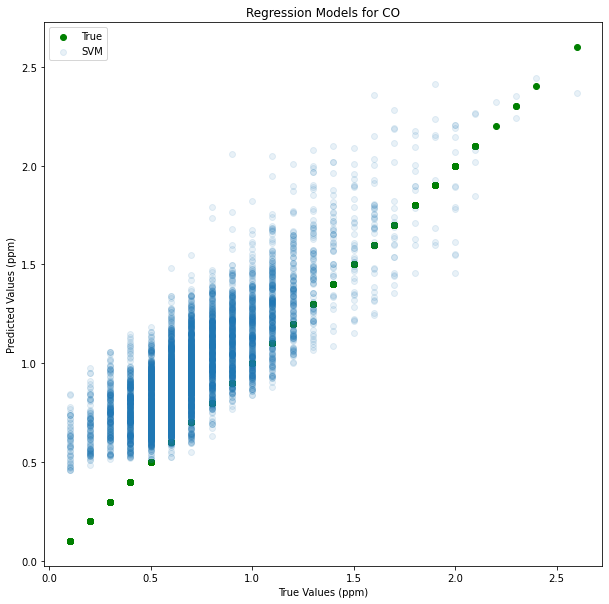

In [578]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test, Y_test, label="True", color="green")
#plt.scatter(Y_test, Y_test_pred_r, label="Random Forest", alpha=0.1)
plt.scatter(Y_test, Y_test_pred_s, label="SVM", alpha=0.1)
#plt.scatter(Y_test, Y_test_pred_g, label="Gradient Boosting", alpha=0.1, color="purple")
plt.legend()
plt.title("Regression Models for CO")
plt.xlabel("True Values (ppm)")
plt.ylabel("Predicted Values (ppm)")
plt.show()

In [469]:
models = []

In [472]:
models.append([sliding, cols, model, svm, gbreg])

In [473]:
models

[RandomForestRegressor(n_estimators=150),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('sgdregressor', SGDRegressor(max_iter=100000000))]),
 GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                           n_estimators=500),
 [72,
  ['PM10',
   'NO2',
   'PM10_1',
   'NO2_1',
   'PM10_2',
   'NO2_2',
   'PM10_3',
   'NO2_3',
   'PM10_4',
   'NO2_4',
   'PM10_5',
   'NO2_5',
   'PM10_6',
   'NO2_6',
   'PM10_7',
   'NO2_7',
   'PM10_8',
   'NO2_8',
   'PM10_9',
   'NO2_9',
   'PM10_10',
   'NO2_10',
   'PM10_11',
   'NO2_11',
   'PM10_12',
   'NO2_12',
   'PM10_13',
   'NO2_13',
   'PM10_14',
   'NO2_14',
   'PM10_15',
   'NO2_15',
   'PM10_16',
   'NO2_16',
   'PM10_17',
   'NO2_17',
   'PM10_18',
   'NO2_18',
   'PM10_19',
   'NO2_19',
   'PM10_20',
   'NO2_20',
   'PM10_21',
   'NO2_21',
   'PM10_22',
   'NO2_22',
   'PM10_23',
   'NO2_23',
   'PM10_24',
   'NO2_24',
   'PM10_25',
   'NO2_25',
   'PM10_26',
   'NO2

In [399]:
sliding = 72
cols = ["PM10", "NO2"]
start = len(cols)
for i in range(sliding-1):
	for x in range(start):
		cols.append(f"{cols[x]}_{i+1}")
cols.append("Time")
dfx2 = pd.DataFrame(columns=cols)
for i, row in tqdm(appa1.iloc[sliding:].iterrows(), total=len(appa1)):
	row_to_add = [row[c] for c in cols[:start]]
	for slid in range(sliding-1):
		row_to_add.extend(appa1.iloc[i-slid-1][c] for c in cols[:start])
	row_to_add.append(row["Time"])
	dfx2.loc[i - sliding] = row_to_add

100%|█████████▉| 17578/17650 [11:38<00:02, 25.18it/s]


In [403]:
dfx2.Time = pd.to_datetime(dfx2.Time)

In [404]:
dfx2["time"] = dfx2["Time"].dt.hour
dfx2["month"] = dfx2["Time"].dt.month


dfx2["weekend"] = (
    dfx2["Time"].dt.dayofweek >= 4
).astype("int")

dfx2["sin_time"] = dfx2["time"].apply(
    lambda x: math.sin(x) * 2 * (math.pi / 24)
)
dfx2["cos_time"] = dfx2["time"].apply(
    lambda x: math.cos(x) * 2 * (math.pi / 24)
)

dfx2["sin_month"] = dfx2["month"].apply(
    lambda x: math.sin(x) * 2 * (math.pi / 12)
)

dfx2["cos_month"] = dfx2["month"].apply(
    lambda x: math.cos(x) * 2 * (math.pi / 12)
)

/var/folders/gl/2h8nn4ps031g1jysgll17wz00000gn/T/ipykernel_2567/1273321946.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfx2["time"] = dfx2["Time"].dt.hour
/var/folders/gl/2h8nn4ps031g1jysgll17wz00000gn/T/ipykernel_2567/1273321946.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfx2["month"] = dfx2["Time"].dt.month
/var/folders/gl/2h8nn4ps031g1jysgll17wz00000gn/T/ipykernel_2567/1273321946.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which h

In [405]:
dfx2

,PM10,NO2,PM10_1,NO2_1,PM10_2,NO2_2,PM10_3,NO2_3,PM10_4,NO2_4,...,PM10_71,NO2_71,Time,time,month,weekend,sin_time,cos_time,sin_month,cos_month
0,9.0,7.0,9.0,5.0,11.0,5.0,10.0,5.0,12.0,10.0,...,18.0,7.0,2020-08-03 04:00:00,4,8,0,-0.198130,-0.171123,0.518027,-0.076184
1,9.0,12.0,9.0,7.0,9.0,5.0,11.0,5.0,10.0,5.0,...,19.0,8.0,2020-08-03 05:00:00,5,8,0,-0.251046,0.074263,0.518027,-0.076184
2,8.0,15.0,9.0,12.0,9.0,7.0,9.0,5.0,11.0,5.0,...,18.0,10.0,2020-08-03 06:00:00,6,8,0,-0.073151,0.251372,0.518027,-0.076184
3,8.0,26.0,8.0,15.0,9.0,12.0,9.0,7.0,9.0,5.0,...,16.0,13.0,2020-08-03 07:00:00,7,8,0,0.171999,0.197371,0.518027,-0.076184
4,8.0,21.0,8.0,26.0,8.0,15.0,9.0,12.0,9.0,7.0,...,16.0,22.0,2020-08-03 08:00:00,8,8,0,0.259013,-0.038092,0.518027,-0.076184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17574,27.0,15.0,27.0,15.0,25.0,16.0,23.0,14.0,20.0,14.0,...,24.0,14.0,2022-07-25 20:00:00,20,7,0,0.239009,0.106836,0.343997,0.394742
17575,32.0,11.0,32.0,11.0,27.0,15.0,25.0,16.0,23.0,14.0,...,27.0,15.0,2022-07-25 21:00:00,21,7,0,0.219036,-0.143395,0.343997,0.394742
17576,28.0,7.0,28.0,7.0,32.0,11.0,27.0,15.0,25.0,16.0,...,33.0,24.0,2022-07-25 22:00:00,22,7,0,-0.002317,-0.261789,0.343997,0.394742
17577,29.0,8.0,29.0,8.0,28.0,7.0,32.0,11.0,27.0,15.0,...,39.0,22.0,2022-07-25 23:00:00,23,7,0,-0.221540,-0.139495,0.343997,0.394742


In [425]:
appa1.CO = model.predict(dfx2[cols])

/var/folders/gl/2h8nn4ps031g1jysgll17wz00000gn/T/ipykernel_2567/3793368453.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  appa1.CO = model.predict(dfx2[cols])


In [429]:
appa1 = appa1.iloc[sliding:].assign(CO=model.predict(dfx2[cols]))

In [430]:
corr = appa1[(appa1["Time"] > '2022-01-01') & (appa1["Time"] < '2022-01-31')][["PM10", "NO2", "SO2", "O3", "CO"]].corr()
corr.style.background_gradient(cmap="coolwarm")

,PM10,NO2,SO2,O3,CO
PM10,1.000000,0.540589,0.473543,-0.590956,0.807473
NO2,0.540589,1.000000,0.756000,-0.731285,0.856272
SO2,0.473543,0.756000,1.000000,-0.472522,0.728356
O3,-0.590956,-0.731285,-0.472522,1.000000,-0.658851
CO,0.807473,0.856272,0.728356,-0.658851,1.000000


In [587]:
appa1.to_csv("exports/appa1_gt_clean_withCO.csv")

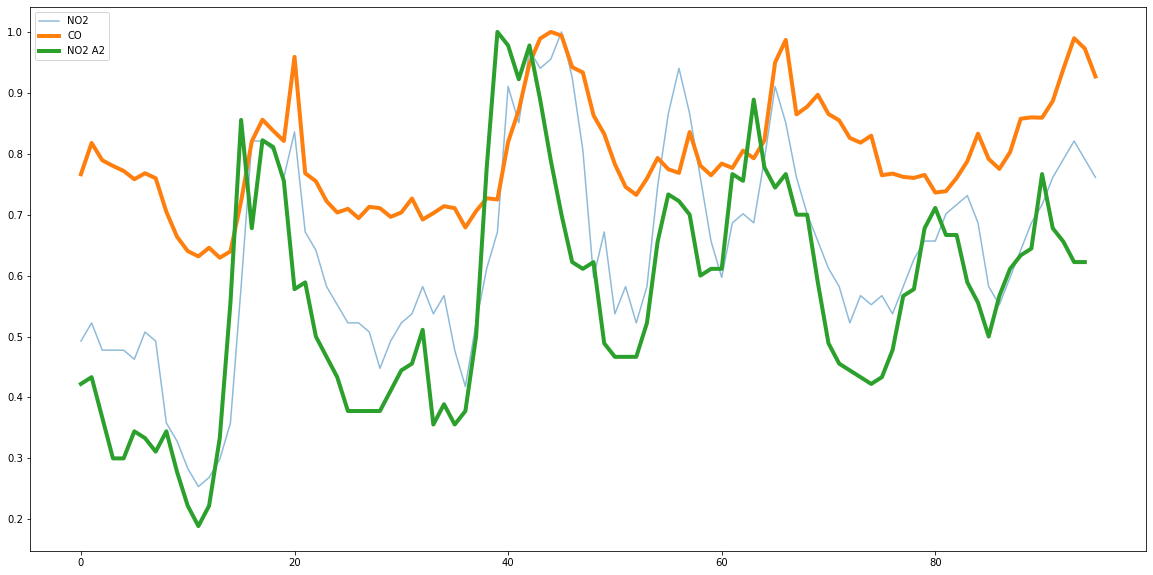

In [612]:
fig = plt.figure(figsize=(20,10))
plt.plot(norm(appa1[(appa1["Time"] > '2022-01-01') & (appa1["Time"] < '2022-01-05')].NO2.to_numpy()), label="NO2", alpha=0.5)
#plt.plot(norm(appa1[(appa1["Time"] > '2022-01-01') & (appa1["Time"] < '2022-01-05')].SO2.to_numpy()), label="SO2", alpha=0.5)
#plt.plot(norm(appa1[(appa1["Time"] > '2022-01-01') & (appa1["Time"] < '2022-01-05')].O3.to_numpy()), label="O3", alpha=0.5)
plt.plot(norm(appa1[(appa1["Time"] > '2022-01-01') & (appa1["Time"] < '2022-01-05')].CO.to_numpy()), label="CO", linewidth=4)
#plt.plot(norm(appa2[(appa2["Time"] > '2022-01-01') & (appa2["Time"] < '2022-01-05')].CO.to_numpy()), label="CO A2", linewidth=4)
plt.plot(norm(appa2[(appa2["Time"] > '2022-01-01') & (appa2["Time"] < '2022-01-05')].NO2.to_numpy()), label="NO2 A2", linewidth=4)
plt.legend()
plt.show()